# Intraquarter variability exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.io import fits
import lightkurve as lk
%config InlineBackend.figure_format='retina'

In [2]:
kepid = 4997179

In [3]:
#sr = lk.search_lightcurve('KIC 5818116')
sr = lk.search_lightcurve('KIC {}'.format(kepid))
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr004997179,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr004997179,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr004997179,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr004997179,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr004997179,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr004997179,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr004997179,0.0
7,Kepler Quarter 08,2011,Kepler,1800,kplr004997179,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr004997179,0.0


In [4]:
lcs_raw = sr.download_all()

In [24]:
#lcs =  lk.LightCurveCollection([lc.SAP_FLUX.normalize() for lc in lcs_raw])
lcs =  lk.LightCurveCollection([lc.PDCSAP_FLUX.normalize() for lc in lcs_raw])

/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_14613/1081608470.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lcs =  lk.LightCurveCollection([lc.PDCSAP_FLUX.normalize() for lc in lcs_raw])


### Fetch the `f3` photometry for this source

In [25]:
times = np.array([54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,
                  54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,
                  55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,
                  55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,
                  55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,
                  55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,
                  55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
                  56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,
                  56303.6729488,56330.563549,56357.495041,56390.4952381])

ffidata = pd.read_csv('../../data/f3/lc_data_new.out')

In [26]:
times_bkjd = times + 2400000.5 - 2454833.0

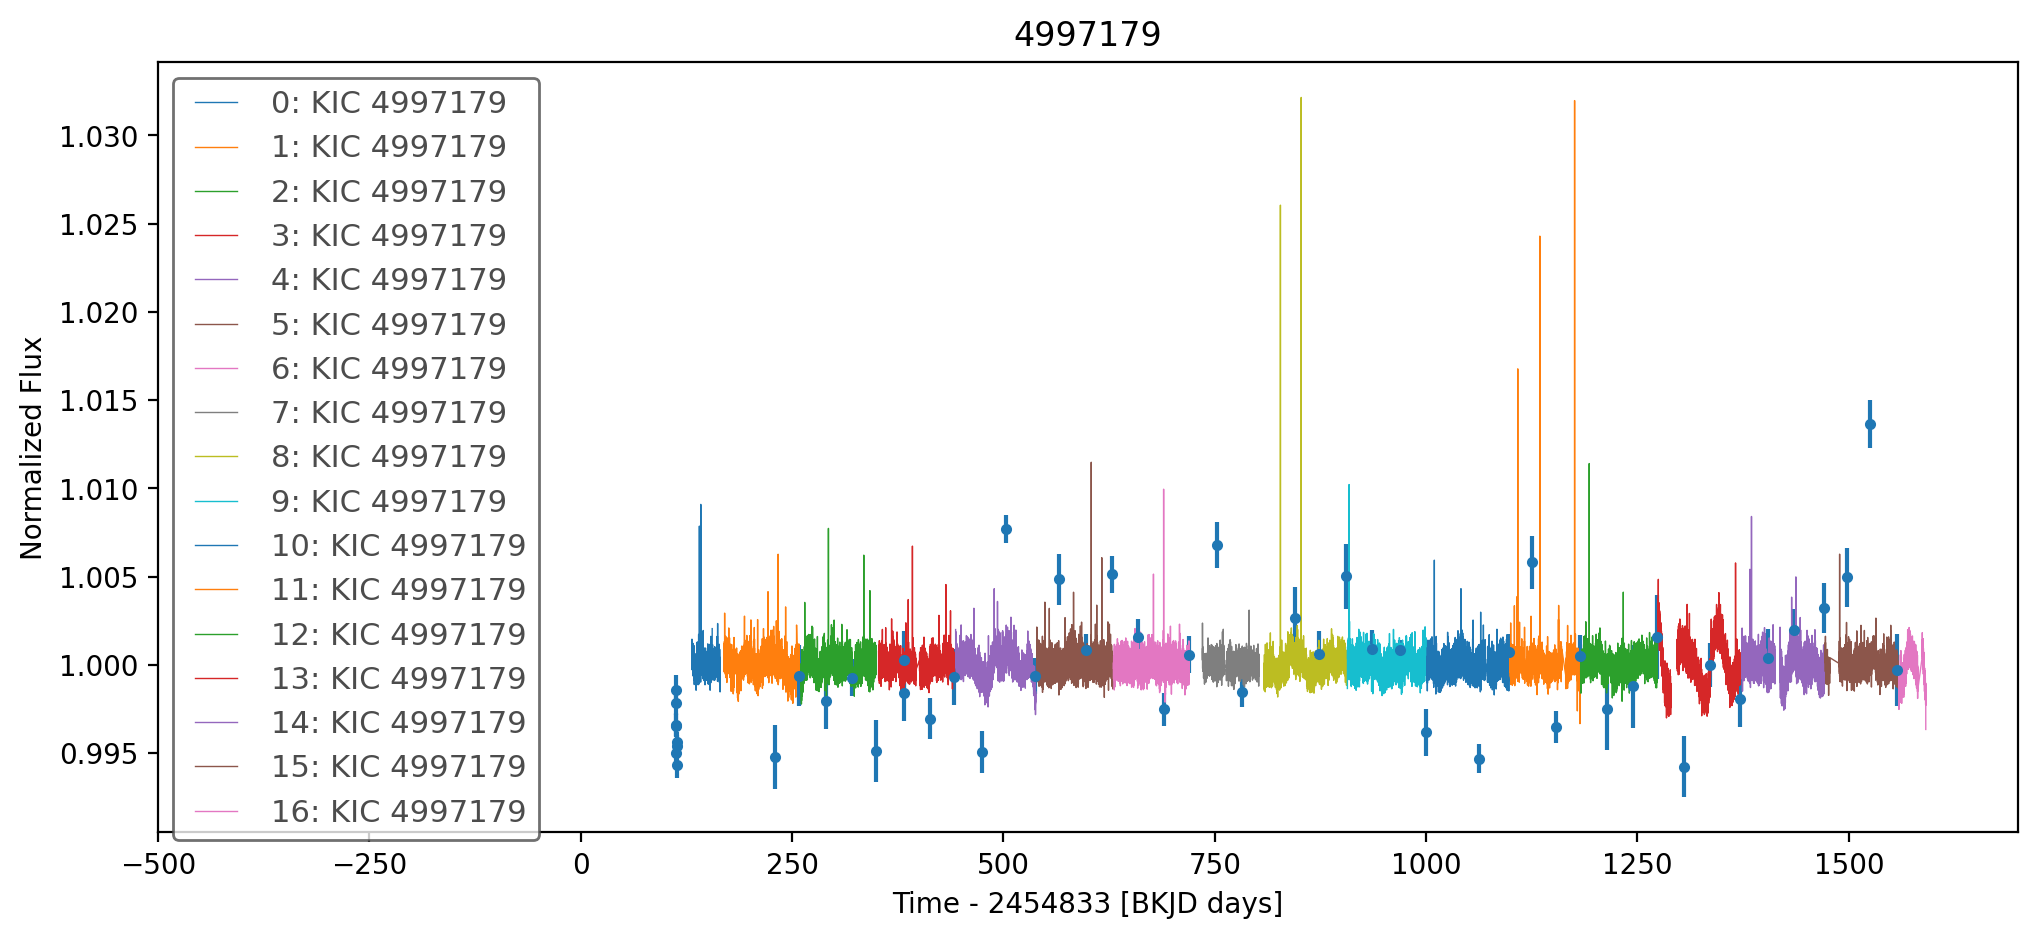

In [27]:
flux = ffidata[ffidata['KIC'] == kepid].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == kepid].iloc[:,-52:]

fig, ax = plt.subplots(figsize=(12,5))
ax.errorbar(times-54833, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
ax.set_xlabel('Time')
ax.set_ylabel('Normalised Flux')
ax.set_title(kepid)

lcs.plot(ax=ax)
ax.set_xlim(-500,1700);
#ax.set_xlim(550,580);
#plt.ylim(0.8, 1.2)

In [28]:
#lc_f3 = lk.LightCurve(time=times, flux=flux.values[0], flux_err=yerr.values[0])
#pg = lc_f3.to_periodogram()
#pg.period_at_max_power

### Let's compute the amplitude in each quarter

In [29]:
lc_global = lcs.stitch().remove_nans().normalize()
pg = lc_global.to_periodogram()
period_global = pg.period_at_max_power.value

In [30]:
period_global

45.04595578786192

Let's fit a sine wave with a design matrix:

$f_\mathrm{model} = A\sin{\frac{2\pi t}{P}} + B\cos{\frac{2\pi t}{P}} + C +Dt+Et^2$ 

The overall amplitude, $\alpha \equiv \sqrt{A^2 + B^2}$

Let's make a function that takes in the lightcurves and returns a dictionary of outputs.

In [31]:
def design_matrix(time_vector, period_global):
    '''Make a sine wave model based on a design matrix'''
    sine_term = np.sin(2.0*np.pi*time_vector/period_global)
    cos_term = np.cos(2.0*np.pi*time_vector/period_global)
    constant = np.ones_like(time_vector)
    linear_term = time_vector
    quadratic_term = time_vector**2
    design_matrix = np.vstack([sine_term, cos_term, constant, linear_term, quadratic_term]).T
    return design_matrix

In [32]:
def best_fit_coeffs(time, y, yerr, period_global):
    '''Get the best fit coefficients from linear algebra'''
    A = design_matrix(time, period_global)
    ATA = np.dot(A.T, A/yerr[:, None]**2)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
    return mean_w

In [33]:
coeffs = best_fit_coeffs(lc_global.time.value, lc_global.flux.value, lc_global.flux_err.value, 
                         period_global=period_global)

In [34]:
flux_model = np.dot(design_matrix(lc_global.time.value, period_global), coeffs)

In [35]:
flux_model

array([1.00014498, 1.00014504, 1.0001451 , ..., 0.99988954, 0.99988925,
       0.99988895])

In [36]:
A, B, C, D, E = coeffs

In [37]:
amp = np.hypot(A, B)

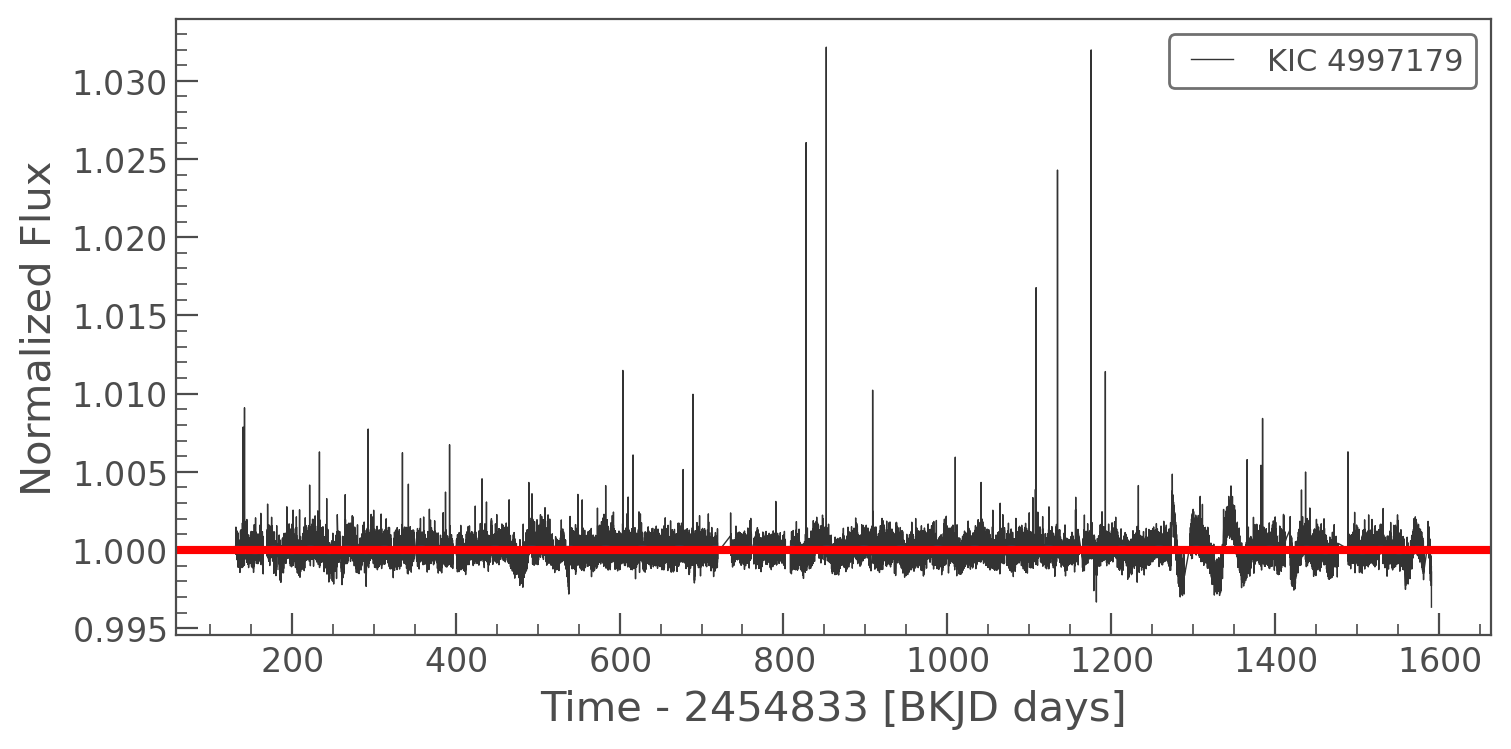

In [38]:
ax = lc_global.plot()
#pg.model(lc_global.time).plot(ax=ax, lw=2);

ax.plot(lc_global.time.value, flux_model, alpha=0.3)
#plt.ylim(0.99, 1.01)
ax.axhline(1+amp, color='r')
ax.axhline(1-amp, color='r')
#plt.xlim(550, 580)

Nice! Not let's *force* the measurement over $\pm15$-day segments.

In [39]:
result_df = pd.DataFrame(data={'time_bkjd':times_bkjd,
                               'flux':flux.values.reshape(-1),
                               'flux_unc':yerr.values.reshape(-1)})
result_df['lc_amp_pm30'] = np.NaN

(0.98, 1.02)

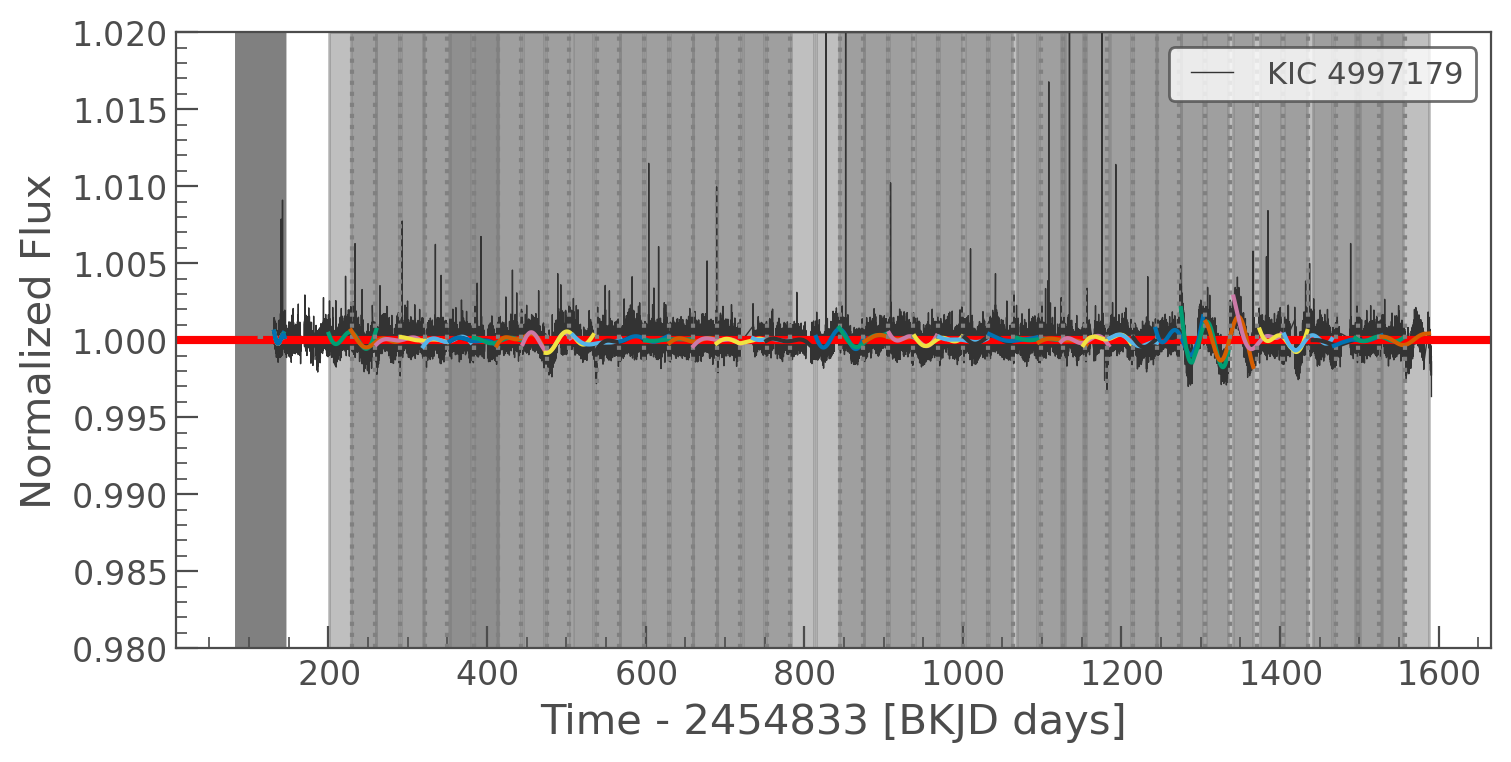

In [40]:
ax = lc_global.plot()
#pg.model(lc_global.time).plot(ax=ax, lw=2);

#plt.ylim(0.99, 1.01)
ax.axhline(1+amp, color='r')
ax.axhline(1-amp, color='r')

dt=30

for i, time in enumerate(times_bkjd):
    t_lo, t_hi = time-dt, time+dt
    mask = (lc_global.time.value > t_lo) & (lc_global.time.value < t_hi)
    if mask.sum() > 13:
        lc = lc_global[mask]
        coeffs = best_fit_coeffs(lc.time.value, lc.flux.value, lc.flux_err.value, period_global)
        amplitude = np.hypot(coeffs[0], coeffs[1])
        result_df.loc[i, 'lc_amp_pm30'] = amplitude
        flux_model = np.dot(design_matrix(lc.time.value, period_global), coeffs)
        ax.plot(lc.time.value, flux_model)
        ax.axvline(time, color='gray', linestyle='dotted')
        ax.fill_between([t_lo, t_hi],[1.02, 1.02], [0.98, 0.98], color='gray', alpha=0.5)
        
        
ax.set_ylim(0.98, 1.02)    
#ax.set_xlim(300, 500)

In [41]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

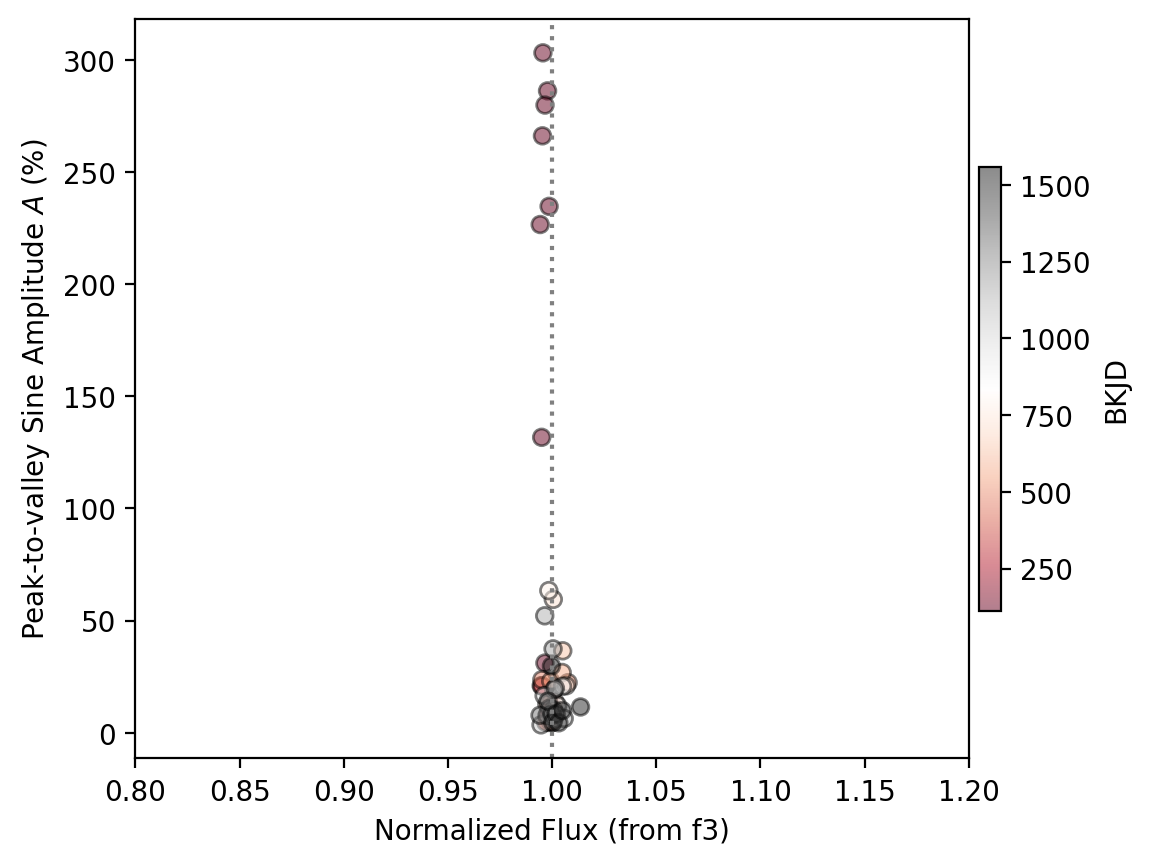

In [23]:
cmap = plt.cm.get_cmap('RdGy')
sc = plt.scatter(result_df.flux, result_df.lc_amp_pm30*2*100, c=result_df.time_bkjd, 
            marker='o', ec='k', alpha=0.5, cmap=cmap)
#plt.errorbar(result_df.flux, result_df.lc_amp_pm30*2*100, xerr=result_df.flux_unc, fmt='none', color='k')
cb = plt.colorbar(sc, shrink=0.6, pad=0.01)
cb.set_label('BKJD', rotation=90)

plt.xlabel('Normalized Flux (from f3)')
plt.ylabel('Peak-to-valley Sine Amplitude $A$ (%)')
plt.xlim(0.8, 1.2)
#plt.ylim(0, 2)
plt.axvline(1.0, linestyle='dotted', color='gray');
#plt.savefig('stellar_cycle_f3_demo.png', dpi=300, bbox_inches='tight')